In [2]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

import covid
import covid.util as util

# Load Data and Set Parameters

In [5]:
data = util.load_data()
place = 'Italy'

util.run_place(data, 
               place, 
               start='2020-03-04', 
               end='2020-04-15',
               T_future=4*7,
               num_warmup=1000, 
               num_samples=1000)

 * running MCMC


sample: 100%|██████████| 2000/2000 [04:52<00:00,  6.85it/s, 511 steps of size 1.10e-02. acc. prob=0.93] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          D0     96.56      3.06     97.42     92.39     99.99   1460.50      1.00
          E0   9218.68   7993.39   6917.47     33.68  20682.19    687.18      1.00
          H0    181.82     97.45    169.97     31.92    331.10    580.92      1.00
          I0   9251.75   2139.34   8918.70   5646.98  12229.37    527.41      1.00
     beta[0]      1.40      0.61      1.27      0.57      2.27    211.45      1.00
     beta[1]      1.43      0.59      1.33      0.63      2.31    279.17      1.00
     beta[2]      1.46      0.60      1.33      0.66      2.37    383.19      1.00
     beta[3]      1.52      0.62      1.39      0.65      2.33    458.98      1.00
     beta[4]      1.53      0.62      1.41      0.68      2.34    707.83      1.00
     beta[5]      1.52      0.58      1.42      0.70      2.35    834.22      1.00
     beta[6]      1.51      0.57      1.40      0.67      2.31    802.98      1.00
   

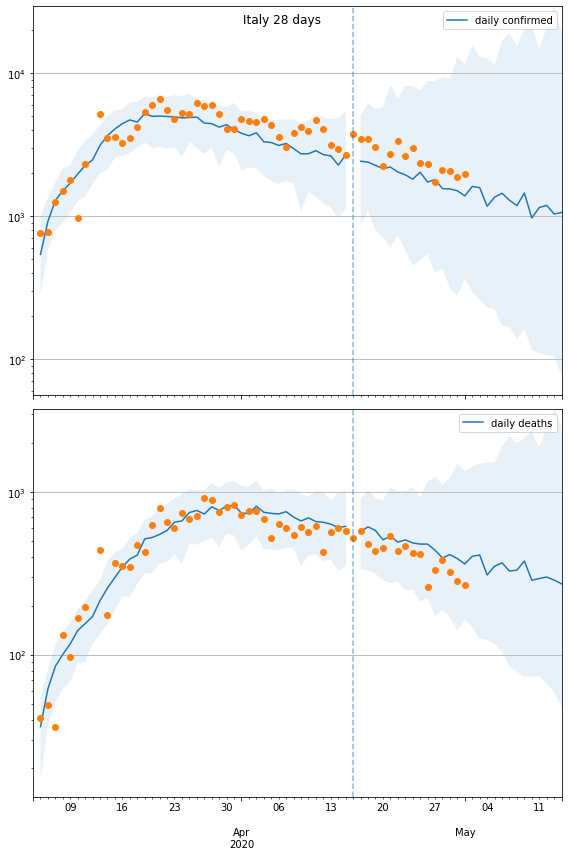

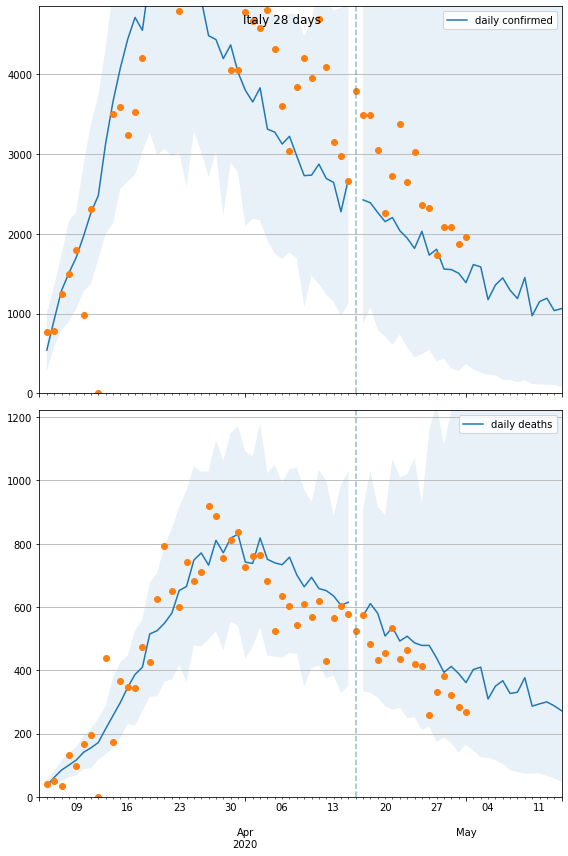

<Figure size 360x216 with 0 Axes>

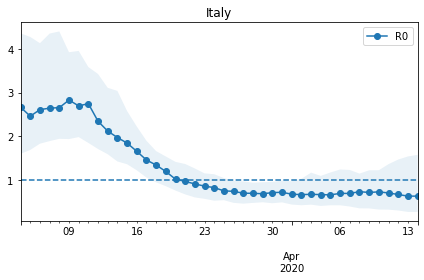

In [4]:
data = util.load_data()
place = 'Italy'
util.gen_forecasts(data, place)

In [ ]:
%debug


In [ ]:
place = 'Italy'
start = '2020-03-04'
end = '2020-04-15'
T_future = 4*7
legend=True
ax = None
plot_fields = ['y', 'z']

prior_samples, mcmc_samples, post_pred_samples, forecast_samples = \
    util.load_samples(place)

place_data = data[place]['data'][start:]
confirmed = place_data.confirmed
death = place_data.death

util.plot_forecast(model,
                   post_pred_samples, 
                   forecast_samples,
                   T_future,
                   confirmed,
                   start='2020-03-04',
                   scale='lin',
                   death = death,
                   daily = False)

In [ ]:
data = util.load_world_data()
model = covid.models.SEIRD.SEIRD()

model.plot_forecast('y', 
                    post_pred_samples, 
                    forecast_samples,
                    start,
                    T_future=7*4,
                    obs=confirmed)

plt.show()

In [ ]:
%debug

In [ ]:
place = 'Italy'
start = '2020-03-04'
end = '2020-04-15'
T_future = 4*7
legend=True
ax = None
plot_fields = ['y', 'z']

prior_samples, mcmc_samples, post_pred_samples, forecast_samples = \
    util.load_samples(place)

confirmed = data[place]['data'].confirmed[start:]
death = data[place]['data'].deaths[start:]

fig, ax = plt.subplots(figsize=(8,5))

# Plot posterior predictive
t = pd.date_range(start=start, end=end, freq="D")
model.plot_samples(post_pred_samples, ax=ax, t=t, plot_fields=plot_fields)

# Plot forecast predictive
forecast_start = pd.to_datetime(end) + pd.Timedelta("1d")
t = pd.date_range(start=forecast_start, periods=T_future, freq="1d")
med, _ = model.plot_samples(forecast_samples, 
                            ax=ax, 
                            t=t, 
                            legend=False, 
                            plot_fields=plot_fields,
                            forecast=True)

# Plot observed
confirmed.plot(style='.')
death.plot(style='.')
ax.axvline(end, linestyle='--', alpha=0.5)
#ax.set_yscale('log')
ax.set_ylim(top=2*med.max())
plt.title(place)
plt.show()


# Compute error
# cum/incident confirmed/death
#

In [ ]:
## Validation: can only do cumulative for now...

# cumulative deaths 
start = forecast_start
end = death.index.max()

obs = death[start:end]

T = len(obs)
z = model.get(forecast_samples, 'z', forecast=True)[:,:T]
df = pd.DataFrame(index=obs.index, data=z.T)

point_forecast = df.median(axis=1)
err = (obs-point_forecast).rename('err')
err.plot(style='o')

mae = err.abs().mean()

plt.title(f"{place} MAE={mae:.2f}")
plt.show()

#display(df[0]-actual)
# T_obs = len(actual)
# pred = np.median(forecast_samples['z_future'][:,:T_obs], axis=0)

# err_c = np.abs(pred-actual)
# plt.plot(pred, actual, 'o')
# plt.show()

In [ ]:

prob_model.set_data()
prob_model()  # __call__
prob_model.deaths(samples, forecast=True, daily=True)
prob_model.cases(samples, forecast=True, daily=True)

prob_model.get(samples, 'S')




deaths = prob_model.cumulative_deaths(samples)

In [ ]:

class foo():
    
    def __init__(self, a):
        self.a = a
        
        
    def __call__(self):
        print(self.a)
        
f = foo(1)
f()


In [ ]:
d1 = {'a': 1, 'b': 2}
d2 = {'a': 100, 'c': 3}
d3 = {'d': 4}

d = dict(d2, **d1, **d3)

print(d)

In [ ]:
x = min(10, 20, -100)
print(x)